# This notebook is to show how we can reduce the simulation time on RPT, by getting R_0 and set a big time period for C/10

In [1]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2

In [2]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import random;import time, signal
fs=10;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip/Rio_Code/Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2 import * 
# pb.set_logging_level("INFO")

In [3]:
model = pb.lithium_ion.DFN(
    options={
    "SEI": "interstitial-diffusion limited",
    "SEI on cracks": "true",
    "lithium plating": "none",
    "lithium plating porosity change":"false",
    "particle mechanics": "constant cracks",
    "loss of active material": "none",
    "contact resistance": "true",
    "open-circuit potential": "current sigmoid",
    "SEI film resistance": "distributed", 
    "SEI porosity change": "true",
    "thermal": "lumped",
} 
)
param = pb.ParameterValues("OKane2023")

param.update({"Inner SEI lithium interstitial diffusivity [m2.s-1]": 2.68e-18})
param.update({"Outer SEI partial molar volume [m3.mol-1]": 9.585e-5})
param.update({"Contact resistance [Ohm]": 0.013})
cap_loss = 5 - 4.86491
param = Overwrite_Initial_L_SEI_0_Neg_Porosity(param,cap_loss)

# use electrolyte
V_max = 4.2;        V_min = 2.5; 
exp_RPT_0p1C_text = [ (
    f"Discharge at 0.1 C until {V_min} V", # (20 minute period)  (1 minute period)  
    "Rest for 1 hours (5 minute period)",  
    f"Charge at 0.1 C until {V_max} V",  #  (20 minute period)
    "Rest for 1 hours (5 minute period)",
    ) ]
exp_RPT_refill_text = [ (
    f"Charge at 0.3C until {V_max} V",  
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (5 minute period)",  
    ) ]
exp_RPT_GITT_text = [ (
    "Rest for 1.2 seconds (0.1 second period)",  
    f"Discharge at C/2 for 4.8 minutes or until {V_min}V (0.1 second period)",
    "Rest for 1 hour", # (5 minute period)  
    ) ]
exp_RPT_C_2_text = [ (
    f"Discharge at C/2 until {V_min}V",
    "Rest for 1 hour (5 minute period)",  
    ) ]
exp_RPT_C_sp_text = [ (
    f"Discharge at C/2 for 0.1 second (0.005 second period)",
    #"Rest for 1 hour (5 minute period)",  
    ) ]
# how to get 0.1s Resistance: voltage: mean of rest step [-10:-1] data points; don't include the last data points of rest step!;
# should also get OCV and SOC 
Exp_GITT = pb.Experiment( exp_RPT_refill_text*1 +   exp_RPT_GITT_text*24 ) # +  exp_RPT_refill_text*1 +   exp_RPT_GITT_text*24
Exp_C_2_DC = pb.Experiment( exp_RPT_refill_text*1 +   exp_RPT_C_2_text*1 )
Exp_C_10_DC = pb.Experiment( exp_RPT_refill_text*1 +   exp_RPT_0p1C_text*1 )
Exp_pulse = pb.Experiment(  exp_RPT_C_sp_text*1 )
var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 60,  # negative particle
    "r_p": 30,  # positive particle
}


Has Overwritten Initial outer SEI thickness [m] to be 1.24e-08 and Negative electrode porosity to be 0.222 to account for initial capacity loss of 0.135 Ah


In [4]:
# CasadiSolver
sim_GITT = pb.Simulation(
    model, 
    experiment=Exp_GITT,
    parameter_values=param,
    solver=pb.CasadiSolver(return_solution_if_failed_early=True),
    var_pts=var_pts,
)
sol_GITT = sim_GITT.solve()

At t = 243.191, , mxstep steps taken before reaching tout.
At t = 243.191, , mxstep steps taken before reaching tout.
At t = 93.1906, , mxstep steps taken before reaching tout.
At t = 93.1906, , mxstep steps taken before reaching tout.
At t = 93.1906, , mxstep steps taken before reaching tout.


In [5]:
sim_sp = pb.Simulation(
    model, 
    experiment=Exp_pulse,
    parameter_values=param,
    solver=pb.CasadiSolver(return_solution_if_failed_early=True),
    var_pts=var_pts,
)
sol_sp = sim_sp.solve()

In [6]:
model.variables.search("Negative")

Average negative particle concentration
Average negative particle concentration [mol.m-3]
Battery negative electrode bulk open-circuit potential [V]
Battery negative particle concentration overpotential [V]
Gradient of negative electrode potential [V.m-1]
Gradient of negative electrolyte potential [V.m-1]
Loss of active material in negative electrode [%]
Loss of lithium due to loss of active material in negative electrode [mol]
Maximum negative particle concentration
Maximum negative particle concentration [mol.m-3]
Maximum negative particle surface concentration
Maximum negative particle surface concentration [mol.m-3]
Minimum negative particle concentration
Minimum negative particle concentration [mol.m-3]
Minimum negative particle surface concentration
Minimum negative particle surface concentration [mol.m-3]
Negative crack surface to volume ratio [m-1]
Negative current collector potential [V]
Negative current collector temperature [C]
Negative current collector temperature [K]
Nega

In [7]:
sim_C_10 = pb.Simulation(
    model, 
    experiment=Exp_C_10_DC,
    parameter_values=param,
    solver=pb.CasadiSolver(return_solution_if_failed_early=True),
    var_pts=var_pts,
)
sol_C_10 = sim_C_10.solve()

In [8]:
sim_C_2 = pb.Simulation(
    model, 
    experiment=Exp_C_2_DC,
    parameter_values=param,
    solver=pb.CasadiSolver(return_solution_if_failed_early=True),
    var_pts=var_pts,
)
sol_C_2 = sim_C_2.solve()

At t = 335.038, , mxstep steps taken before reaching tout.
At t = 95.038 and h = 6.03776e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 95.038, , mxstep steps taken before reaching tout.


Total data points:  128
Applied current [A]: 2.5
Total data points:  1192
Applied current [A]: 0.5


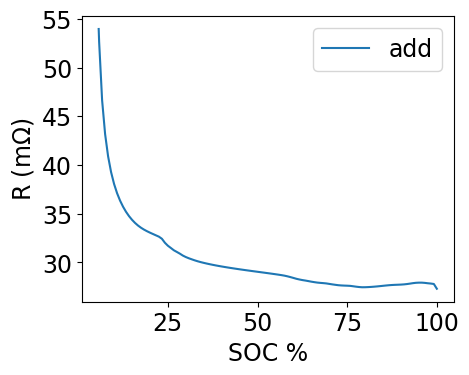

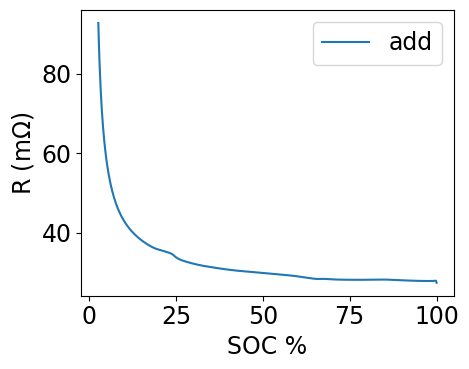

In [9]:
# Get R during constant discharge (no matter what current rate is) 
# at the right SOC

def Get_R_from_Constant_Discharge(sol_C_2,cyc_no,cap_full):
    print("Total data points: ",len(sol_C_2.cycles[1]["Time [h]"].entries))
    cycle = sol_C_2.cycles[cyc_no]
    Dis_Cap = abs(
        cycle.steps[0]["Discharge capacity [A.h]"].entries[0] 
        - cycle.steps[0]["Discharge capacity [A.h]"].entries )
    SOC_CD = (1-Dis_Cap/cap_full)*100
    #print(SOC_CD)
    V_ohmic = (
    cycle.steps[0]['Battery open-circuit voltage [V]'].entries 
    - cycle.steps[0]["Terminal voltage [V]"].entries

    + cycle.steps[0]["Battery particle concentration overpotential [V]"].entries 
    + cycle.steps[0]["X-averaged battery concentration overpotential [V]" ].entries
    #+ cycle.steps[0]["X-averaged battery reaction overpotential [V]" ].entries
    )#
    """ V_ohmic_2 = (
    - cycle.steps[0]["X-averaged battery electrolyte ohmic losses [V]"].entries 
    - cycle.steps[0]["X-averaged battery solid phase ohmic losses [V]"].entries
    #+ 0.013*cycle.steps[0]["Current [A]"].entries[0]
    ) """
    print("Applied current [A]:",cycle.steps[0]["Current [A]"].entries[0])
    Rohmic_CD = V_ohmic/cycle.steps[0]["Current [A]"].entries[0] * 1e3
    # Rohmic_CD_2 = V_ohmic_2/cycle.steps[0]["Current [A]"].entries[0] * 1e3 + 13
    fig, ax = plt.subplots( figsize=(5,4),tight_layout=True)
    #ax.plot(SOC_CD,Rohmic_CD_2,label="subtract")
    ax.plot(SOC_CD,Rohmic_CD,label="add")
    ax.set_xlabel("SOC %")
    ax.set_ylabel(r'R (m$\Omega$)')
    ax.legend()
    return SOC_CD,Rohmic_CD   #,Rohmic_CD_2
SOC_C_2, Rohmic_C_2  = Get_R_from_Constant_Discharge(sol_C_2,cyc_no=1,cap_full = 5)
SOC_C_10,Rohmic_C_10 = Get_R_from_Constant_Discharge(sol_C_10,cyc_no=1,cap_full = 5)

In [10]:
label = ["0",] 
output_variables3 = [
    "Current [A]",
    "Battery open-circuit voltage [V]",
    "Battery particle concentration overpotential [V]",
    "X-averaged battery reaction overpotential [V]",
    "X-averaged battery concentration overpotential [V]",
    "X-averaged battery electrolyte ohmic losses [V]",
    "X-averaged battery solid phase ohmic losses [V]",
]
quick_plot = pb.QuickPlot(
    [sol_sp,], output_variables3,label,variable_limits='fixed',
    time_unit='seconds',n_rows=2) #figsize = (18,12),
quick_plot.dynamic_plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=0.1, step=0.001), Output()), _dom_classes=('…

9.711648674967073 39.43172669249208 91.02663863863789
52.000000000168306 33.0373165262241


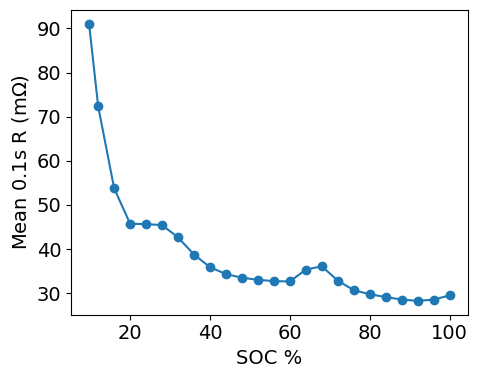

In [18]:
# write a function to get the discharge capacity and resistance
def Get_0p1s_R0(sol_RPT,Index,cap_full):
    Res_0p1s = []; SOC = [100,];
    for i,index in enumerate(Index):
        cycle = sol_RPT.cycles[index]
        Res_0p1s.append(   (
            np.mean(cycle.steps[0]["Terminal voltage [V]"].entries[-10:-1])
            - cycle.steps[1]["Terminal voltage [V]"].entries[0]
        ) / cycle.steps[1]["Current [A]"].entries[0] * 1000)
        if i > 0:
            Dis_Cap = abs(
                cycle.steps[1]["Discharge capacity [A.h]"].entries[0] 
                - cycle.steps[1]["Discharge capacity [A.h]"].entries[-1] )
            SOC.append(SOC[-1]-Dis_Cap/cap_full*100)
    return np.mean(Res_0p1s),Res_0p1s,SOC
cap_full = 5;
Index = np.arange(1,25,1) # index = 2:25
Mean_Res_0p1s,Res_0p1s,SOC = Get_0p1s_R0(sol_GITT,Index,cap_full)

fs=14;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

fig, ax = plt.subplots( figsize=(5,4),tight_layout=True)
ax.plot(SOC,Res_0p1s,"-o")
ax.set_xlabel("SOC %")
ax.set_ylabel(r'Mean 0.1s R (m$\Omega$)')
print(SOC[-1],Mean_Res_0p1s,Res_0p1s[-1])
print(SOC[12],Res_0p1s[12])

In [19]:
# put into the paper
R_C_2_52SOC = np.interp(52,np.flip(SOC_C_2),np.flip(Rohmic_C_2),)
R_C_10_52SOC = np.interp(52,np.flip(SOC_C_10),np.flip(Rohmic_C_10),)
print(R_C_2_52SOC,R_C_10_52SOC)
print(SOC[12],Res_0p1s[12])

28.94197868921776 29.67455238848717
52.000000000168306 33.0373165262241


9.711648674967073 39.43172669249208 91.02663863863789


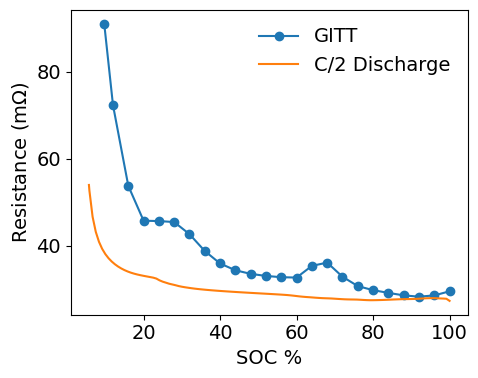

In [20]:
SaveFig_Path = os.path.expanduser("~/EnvPBGEM_Linux/SimSave/P2_R9_Dim/SaveFig") 
Target = "R_231004"
target_folder = os.path.join(SaveFig_Path, Target)
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

fig, ax = plt.subplots( figsize=(5,4),tight_layout=True)
ax.plot(SOC,Res_0p1s,"-o",label =r'GITT' )
ax.plot(SOC_C_2,Rohmic_C_2,label=r'C/2 Discharge')
# ax.plot(SOC_C_10,Rohmic_C_10,label=r'C/10 Discharge')
ax.set_xlabel("SOC %")
ax.set_ylabel(r'Resistance (m$\Omega$)')
ax.legend(loc='best',frameon=False)
print(SOC[-1],Mean_Res_0p1s,Res_0p1s[-1])
#ax.set_ylim(20,50)
plt.savefig(
    target_folder + f"/Compare_R_from_GITT_w_0p5C.png", dpi=800)
plt.savefig(
    target_folder + f"/Compare_R_from_GITT_w_0p5C.svg")